# FRANKFURT TREES - EXPLORATORY DATA ANALYSIS


### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tabulate

from pyproj import Transformer

### Define the projection transformer

In [23]:
# define projection systems
transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")

# Colors
green = '#84B082'
blue = '#7A89C2'
grey = '#333533'

### Load the data and change the projection

In [3]:
df = pd.read_csv('../data/baumauswahl_veroffentlichung_11.csv',
                 sep=';', encoding='ISO-8859-1', decimal=',')

df['lat'], df['lon'] = transformer.transform(df['HOCHWERT'], df['RECHTSWERT'])

### Start the statistics

#### Basic statistics

According to the table below, we have in total 159,677 trees in Frankfurt. 
The dataset has 14 fields, with 2 more added with the lat, lon in the "correct" 
projection.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159677 entries, 0 to 159676
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BAUMNUMMER  159677 non-null  object 
 1   HOCHWERT    159677 non-null  float64
 2   RECHTSWERT  159677 non-null  float64
 3   GATTUNGART  159672 non-null  object 
 4   GATTUNG     159677 non-null  object 
 5   GA_LANG     159677 non-null  object 
 6   KR_DURCHM   159677 non-null  float64
 7   ST_UMFANG   159677 non-null  float64
 8   GEBIET      159677 non-null  object 
 9   STRASSE     159677 non-null  object 
 10  STANDORT    59443 non-null   object 
 11  BAUMHOEHE   159677 non-null  int64  
 12  ST_DURCHM   159677 non-null  int64  
 13  PFLANZJAHR  159677 non-null  int64  
 14  Kr_r        159677 non-null  float64
 15  lat         159677 non-null  float64
 16  lon         159677 non-null  float64
dtypes: float64(7), int64(3), object(7)
memory usage: 20.7+ MB


In [5]:
# check the years of planting
df['PFLANZJAHR'].describe()

count    159677.000000
mean       1979.917490
std          51.837381
min        1700.000000
25%        1969.000000
50%        1983.000000
75%        1997.000000
max       19990.000000
Name: PFLANZJAHR, dtype: float64

We have some weird years, let's see which are wrong:

In [6]:
df.loc[df['PFLANZJAHR'] > 2022]

,BAUMNUMMER,HOCHWERT,RECHTSWERT,GATTUNGART,GATTUNG,GA_LANG,KR_DURCHM,ST_UMFANG,GEBIET,STRASSE,STANDORT,BAUMHOEHE,ST_DURCHM,PFLANZJAHR,Kr_r,lat,lon
76852,40,5.547289e+06,471542.099000,G0057,Acer,"Acer platanoides, Spitz-Ahorn",4.0,35.0,Gr??nanlagen,Goldstein-Sued Gruenzug,NaN,12,11,19990,2.0,3.199193,50.301208
158490,24,5.551940e+06,468911.038333,G0310,Juglans,"Juglans regia, Echte Walnuss",12.0,88.0,Gr??nanlagen,Gruenzug Am Sulzbach,NaN,12,28,2090,6.0,3.179811,50.331693


While tree number 40 can be easily attributed to the year 1999, tree number 24 is a bit trickier.
We can remove it, since it is just one in almost 160k trees.

In [7]:
df.drop(158490, inplace=True)

In [8]:
df.loc[df['PFLANZJAHR'] == 19990, 'PFLANZJAHR'] = 1999

In [9]:
# Add the age
df['age'] = 2022 - df['PFLANZJAHR']

In [10]:
# Average age of trees
round((2022 - df['PFLANZJAHR']).mean(), 0)

42.0

In [11]:
# Which years saw the most trees planted
planting_year = df.groupby('PFLANZJAHR').size().reset_index(name='trees')
planting_year['prop_in_total'] = planting_year['trees'] / planting_year['trees'].sum()
planting_year.nlargest(10, 'trees')

,PFLANZJAHR,trees,prop_in_total
155,1980,11888,0.074451
165,1990,9435,0.059088
145,1970,8810,0.055174
160,1985,5402,0.033831
135,1960,5027,0.031483
125,1950,4986,0.031226
175,2000,4297,0.026911
170,1995,4219,0.026422
150,1975,4200,0.026303
152,1977,3001,0.018794


In [12]:
# How many species do we have?
species_df = df[['GATTUNG']].groupby('GATTUNG').size().reset_index(name='trees').sort_values('trees', ascending=False)
species_df['prop_total'] = species_df['trees'] / species_df['trees'].sum()
species_df['CumSum'] = species_df['trees'].cumsum()
species_df['cumsum_prop_total'] = species_df['CumSum'] / species_df['trees'].sum()
species_df.reset_index(drop=True)

,GATTUNG,trees,prop_total,CumSum,cumsum_prop_total
0,Acer,35499,0.222319,35499,0.222319
1,Tilia,15023,0.094084,50522,0.316403
2,Carpinus,13824,0.086575,64346,0.402979
3,Quercus,13120,0.082166,77466,0.485145
4,Platanus,9162,0.057379,86628,0.542524
...,...,...,...,...,...
135,Cunninghamia,1,0.000006,159672,0.999975
136,Rosa,1,0.000006,159673,0.999981
137,Citrus,1,0.000006,159674,0.999987
138,Berberis,1,0.000006,159675,0.999994


In [16]:
tabulate.tabulate(
    [
        ['%', 'Number of species'],
        ['50%', species_df.loc[species_df['cumsum_prop_total'] <= 0.5].shape[0]],
        ['80%', species_df.loc[species_df['cumsum_prop_total'] <= 0.8].shape[0]],
        ['90%', species_df.loc[species_df['cumsum_prop_total'] <= 0.9].shape[0]],
        ['95%', species_df.loc[species_df['cumsum_prop_total'] <= 0.95].shape[0]],
        ['99%', species_df.loc[species_df['cumsum_prop_total'] <= 0.99].shape[0]],
        ['100%', species_df.shape[0]]
    ], 
    tablefmt='html')

%,Number of species
50%,4
80%,13
90%,21
95%,29
99%,48
100%,140


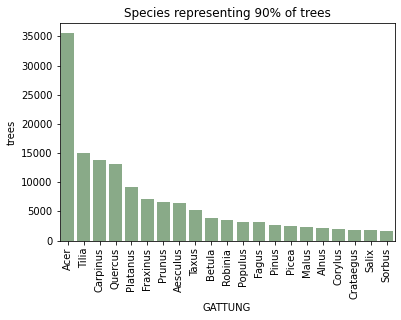

In [22]:
plt.xticks(rotation=90)
sns.barplot(
    x=species_df.loc[species_df['cumsum_prop_total']<0.9, 'GATTUNG'], 
    y=species_df.loc[species_df['cumsum_prop_total']<0.9, 'trees'],
    color=green) \
    .set(title='Species representing 90% of trees')
plt.show()

[Text(0.5, 1.0, 'Height by tree age')]

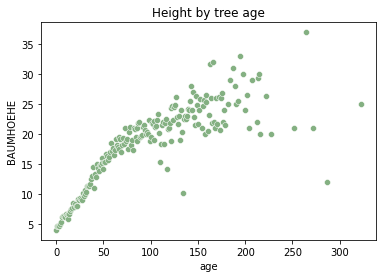

In [24]:
# how does age and hight relate to each other
mean_height = df[['age', 'BAUMHOEHE']].groupby('age').mean().reset_index()
sns.scatterplot(x=mean_height['age'], y=mean_height['BAUMHOEHE'], color=green) \
    .set(title='Height by tree age')

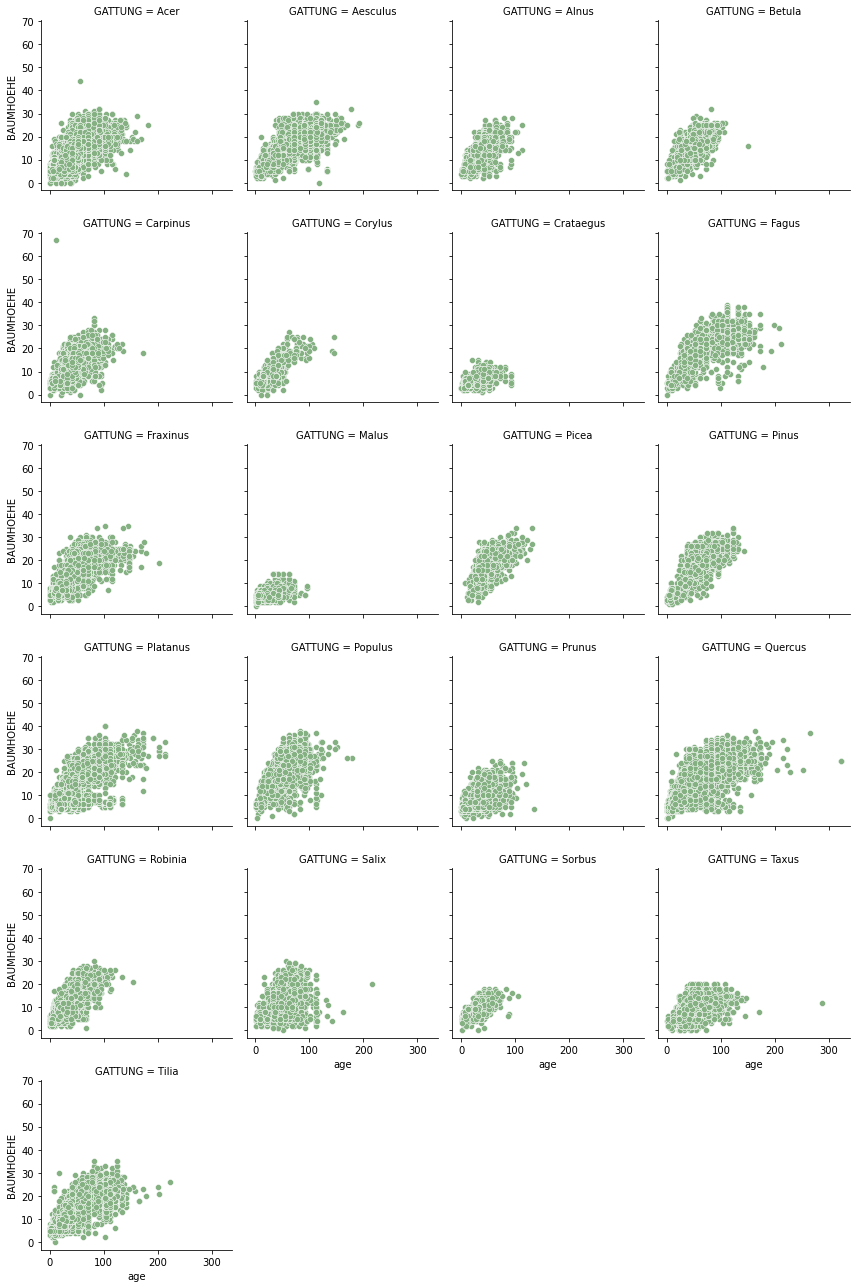

In [32]:
# Is it different by species?
species_grid =  sns.FacetGrid(df.loc[df['GATTUNG'].isin(species_df.loc[species_df['cumsum_prop_total']<0.9, 'GATTUNG'])].sort_values('GATTUNG'), col="GATTUNG", margin_titles=True, col_wrap=4)
species_grid.map(sns.scatterplot, "age", "BAUMHOEHE", color=green)

We do have some dispersion around height and age, which might be caused by several reasons (including bad data).
Let's focus at Acer species:

In [33]:
df_acer = df.loc[df['GATTUNG']=='Acer']